In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import unicodedata

In [2]:
df = pd.read_excel('datasets/cholera_cases_1718.xlsx')
df_20 = pd.read_excel('datasets/cholera_cases_1718.xlsx', sheet_name=1)

In [3]:
df['Governorate'] = df['Governorate'].str.split().apply(lambda x: ' '.join([s for s in x if not any(['arabic' in unicodedata.name(c).lower() for c in s])]))
df = df[df['OnsetMonth'].str.len() > 5]
df = df[['Governorate','OnsetMonth', 'Count of No']]
df['Year'] = df['OnsetMonth'].str.split('-').str[0]
df['Month'] = df['OnsetMonth'].str.split('-').str[1]
df['Month'] = np.where(df['Month'].str.len() == 2, df['Month'], '0'+df['Month'])
df['OnsetMonth'] = pd.to_datetime(df['Year'] + df['Month'], format='%Y%m')
df['OnsetMonth'] = df['OnsetMonth'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
df = df.drop(['Year', 'Month'], axis=1)

In [4]:
gov = df.groupby(['Governorate', 'OnsetMonth']).sum().reset_index()
tot = df.groupby('OnsetMonth')['Count of No'].sum().reset_index()

In [5]:
target_govs = ['Amran', 'Amanat Al Asimah', 'Hajjah', 'Al Hudaydah']

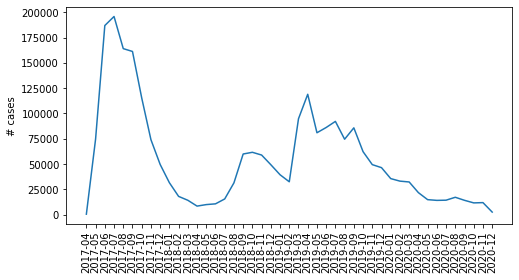

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=tot, x='OnsetMonth', y='Count of No')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('# cases')
plt.show()

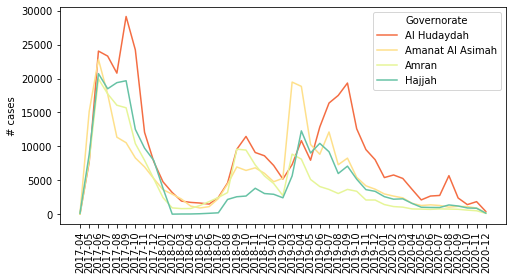

In [7]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(data=gov[gov['Governorate'].isin(target_govs)], 
             x='OnsetMonth', 
             y='Count of No', 
             hue='Governorate',
             palette='Spectral')
plt.xlabel('')
plt.ylabel('# cases')
plt.xticks(rotation=90)
plt.show()
gov[gov['Governorate'].isin(target_govs)].to_csv('cases_by_govt.tsv', 
                                                 sep='\t', 
                                                 index=False)

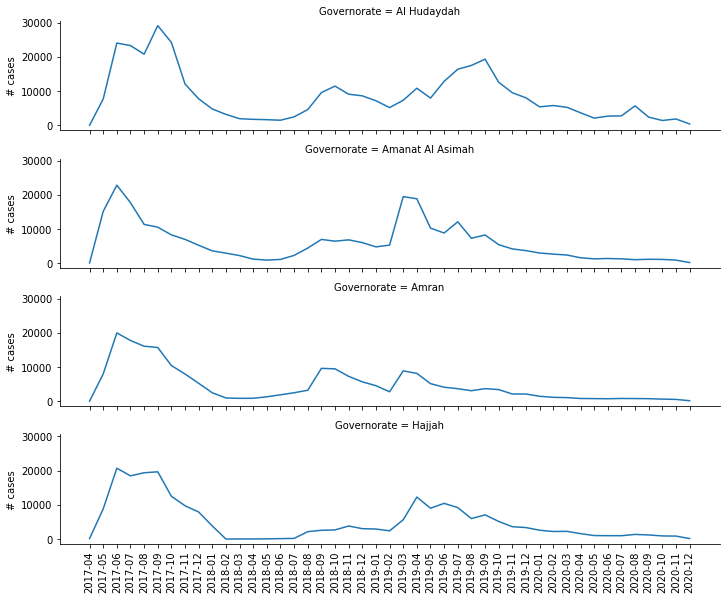

In [8]:
f = sns.relplot(data=gov[gov['Governorate'].isin(target_govs)], 
             x='OnsetMonth', 
             y='Count of No', 
             row='Governorate',
             palette='Spectral', 
             height=2, 
             aspect=5, 
             kind='line')
plt.xticks(rotation=90)
f.set_xlabels('')
f.set_ylabels('# cases')
plt.show()

In [9]:
temp = pd.read_csv('temperature.csv', sep=',')
rainfall = pd.read_csv('rainfall.csv', sep=',')

In [10]:
temp['Statistics'] = temp[' Statistics'].str.split().str[0]
temp['Month'] = pd.to_datetime(temp['Statistics'], format='%b')
temp['Month'] = temp['Month'].dt.date.apply(lambda x: x.strftime('%m'))
temp['Date'] = pd.to_datetime(temp['Month'].astype(str) + temp[' Year'].astype(str))
temp['Date'] = temp['Date'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
temp = temp.drop([' Year', ' Statistics', ' Country', ' ISO3', 'Statistics', 'Month'], axis=1)

In [12]:
rainfall['Statistics'] = rainfall[' Statistics'].str.split().str[0]
rainfall['Month'] = pd.to_datetime(rainfall['Statistics'], format='%b')
rainfall['Month'] = rainfall['Month'].dt.date.apply(lambda x: x.strftime('%m'))
rainfall['Date'] = pd.to_datetime(rainfall['Month'].astype(str) + rainfall[' Year'].astype(str))
rainfall['Date'] = rainfall['Date'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
rainfall = rainfall.drop([' Year', ' Statistics', ' Country', ' ISO3', 'Statistics', 'Month'], axis=1)

In [13]:
gov = gov.merge(rainfall, left_on='OnsetMonth', right_on='Date').drop('Date', axis=1)
gov = gov.merge(temp, left_on='OnsetMonth', right_on='Date').drop('Date', axis=1)
gov = gov.rename({'Count of No': 'cholera_cases', 'Rainfall - (MM)': 'rainfall',
            'Temperature - (Celsius)': 'temperature'}, axis=1)

In [14]:
gov[gov['Governorate'].isin(target_govs)].to_csv('cholera_by_govt.tsv', sep='\t', index=False)

In [15]:
for c in ['cholera_cases', 'rainfall', 'temperature']:
    gov[c] = (gov[c] - gov[c].min()) / (gov[c].max() - gov[c].min() )

In [16]:
tot = tot.merge(rainfall, left_on='OnsetMonth', right_on='Date').drop('Date', axis=1)
tot = tot.merge(temp, left_on='OnsetMonth', right_on='Date').drop('Date', axis=1)
tot = tot.rename({'Count of No': 'cholera_cases', 
                  'Rainfall - (MM)': 'rainfall',
                  'Temperature - (Celsius)': 'temperature'}, axis=1)
tot.to_csv('cholera_overall_normalized.tsv', sep='\t', index=False)
for c in ['cholera_cases', 'rainfall', 'temperature']:
    tot[c] = (tot[c] - tot[c].min()) / (tot[c].max() - tot[c].min() )

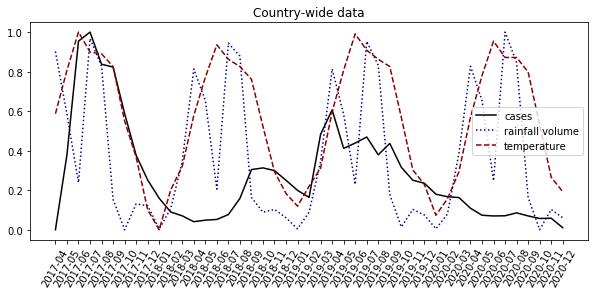

In [17]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=tot, x='OnsetMonth', y='cholera_cases', color='black', label='cases')
sns.lineplot(data=tot, x='OnsetMonth', y='rainfall', linestyle=':', color='darkblue', label='rainfall volume')
sns.lineplot(data=tot, x='OnsetMonth', y='temperature', linestyle='--', color='darkred', label='temperature')
plt.xticks(rotation=60)
plt.xlabel('')
plt.ylabel('')
plt.title('Country-wide data')
plt.show()

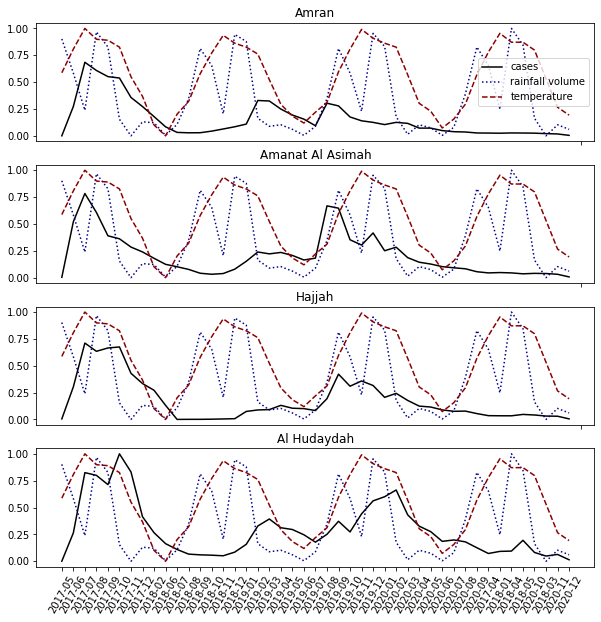

In [36]:
fig, ax = plt.subplots(figsize=(10,10), nrows=4)
for idx, g in enumerate(target_govs):
    dgov = gov[gov['Governorate']==g].sort_values(by='OnsetMonth')
    sns.lineplot(data=dgov, x='OnsetMonth', 
                 y='cholera_cases', color='black', label='cases', ax=ax[idx])
    sns.lineplot(data=dgov, x='OnsetMonth', 
                 y='rainfall', linestyle=':', color='darkblue', label='rainfall volume', ax=ax[idx])
    sns.lineplot(data=dgov, x='OnsetMonth', 
                 y='temperature', linestyle='--', color='darkred', label='temperature', ax=ax[idx])
    if idx != 0:
        ax[idx].get_legend().remove()
    if idx != 3:
        ax[idx].set_xticks('')
    else:
        ax[idx].set_xticklabels(labels=gov[gov['Governorate']==g].OnsetMonth.tolist(), 
                                rotation=60)
    
    ax[idx].set_xlabel('')
    ax[idx].set_ylabel('')
    ax[idx].set_title(g)
plt.show()

In [19]:
gov[gov['Governorate'].isin(target_govs)].to_csv('cholera_by_govt_normalized.tsv', sep='\t', index=False)
tot.to_csv('cholera_overall_normalized.tsv', sep='\t', index=False)